In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import random
import numpy as np
import torch

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

seed = 2023
deterministic = True

random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed_all(seed)

In [ ]:
import pandas as pd
import numpy as np


def makediff(df):
    res = df.copy()
    res['diff'] = df.groupby('id')['Timestamp'].diff()
    res['diff'].fillna(res.groupby('id')['diff'].transform('mean'), inplace=True)
    res['diff'] *= 80
    res['diff'] = np.log2(res['diff'])
    return res


def makeCSV(path, flag):
    df = pd.read_csv(path)
    df = df.dropna()
    df.rename(columns = {'Arbitration_ID' : 'id'}, inplace = True)
    df = makediff(df)
    temp = df['Data'].str.split(expand=True)
    temp.columns = ['d0', 'd1', 'd2', 'd3', 'd4', 'd5', 'd6', 'd7']
    temp = temp.fillna('-1')
    if flag:
        df['Class'] = 'Normal'
        df['SubClass'] = 'Normal'
    df = pd.concat([df.loc[:, 'id'], temp, df.loc[:,['diff', 'Class', 'SubClass']]], axis=1)
    df.to_csv(path[:-4] + '_new.csv', index=False)
    return


# makeCSV('/content/drive/MyDrive/ADD/challenge/0_Preliminary/0_Training/Pre_train_D_0.csv', 1)

df = pd.read_csv('/content/drive/MyDrive/ADD/challenge/0_Preliminary/0_Training/Pre_train_D_0_new.csv')
df.loc[: ,'id':'d7'] = df.loc[: ,'id':'d7'].apply(lambda x: x.astype(str).map(lambda x: int(x, 16)))
df.loc[: ,'id':'d7'] /= 256
df = df[['id', 'diff', 'Class', 'SubClass']]
free = np.array(df)


# makeCSV('/content/drive/MyDrive/ADD/challenge/0_Preliminary/0_Training/Pre_train_D_1.csv', 0)

df = pd.read_csv('/content/drive/MyDrive/ADD/challenge/0_Preliminary/0_Training/Pre_train_D_1_new.csv')
df.loc[: ,'id':'d7'] = df.loc[: ,'id':'d7'].apply(lambda x: x.astype(str).map(lambda x: int(x, 16)))
df.loc[: ,'id':'d7'] /= 256
df = df[['id', 'diff', 'Class', 'SubClass']]
test1 = np.array(df)


# makeCSV('/content/drive/MyDrive/ADD/challenge/0_Preliminary/0_Training/Pre_train_D_2.csv', 0)

df = pd.read_csv('/content/drive/MyDrive/ADD/challenge/0_Preliminary/0_Training/Pre_train_D_2_new.csv')
df.loc[: ,'id':'d7'] = df.loc[: ,'id':'d7'].apply(lambda x: x.astype(str).map(lambda x: int(x, 16)))
df.loc[: ,'id':'d7'] /= 256
df = df[['id', 'diff', 'Class', 'SubClass']]
test2 = np.array(df)


# makeCSV('/content/drive/MyDrive/ADD/challenge/0_Preliminary/1_Submission/Pre_submit_D.csv', 0)

df = pd.read_csv('/content/drive/MyDrive/ADD/challenge/0_Preliminary/1_Submission/Pre_submit_D_new.csv')
df.loc[: ,'id':'d7'] = df.loc[: ,'id':'d7'].apply(lambda x: x.astype(str).map(lambda x: int(x, 16)))
df.loc[: ,'id':'d7'] /= 256
df = df[['id', 'diff', 'Class', 'SubClass']]
test3 = np.array(df)

<ipython-input-3-1d5522b423e4>:33: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  df.loc[: ,'id':'d7'] = df.loc[: ,'id':'d7'].apply(lambda x: x.astype(str).map(lambda x: int(x, 16)))
<ipython-input-3-1d5522b423e4>:42: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  df.loc[: ,'id':'d7'] = df.loc[: ,'id':'d7'].apply(lambda x: x.astype(str).map(lambda x: int(x, 16)))
<ipython-input-3-1d5522b423e4>:51: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To

In [ ]:
import torch
import numpy as np
from torch.utils.data import Dataset, DataLoader, random_split


N = 200
d = 50


def makeDataset(data):
    X, Y = list(), list() #normal 데이터셋
    XX, YY = list(), list() #attack 데이터셋
    for i in range(0, len(data), d):
        if i + N < len(data):
            temp = data[i:i+N]
            flag = 1
            for t in temp:
                if t[-2] == 'Attack':
                    a = np.array(temp[:, :-2]).astype(np.float32)
                    XX.append(torch.tensor(a, dtype=torch.float32))
                    YY.append(t[-1])
                    flag = 0
                    break
            if flag:
                a = np.array(temp[:, :-2]).astype(np.float32)
                X.append(torch.tensor(a, dtype=torch.float32))
                Y.append(t[-1])
    return X, Y, XX, YY


class CustomDataset(Dataset):
    def __init__(self, x, y):
        self.x = x
        self.y = y

    def __len__(self):
        return len(self.x)

    def __getitem__(self, index):
        return self.x[index], self.y[index]


trainX, trainY, _, _ = makeDataset(free)
norX, norY, attX, attY = makeDataset(test1)
norX2, norY2, attX2, attY2 = makeDataset(test2)

dataset = CustomDataset(trainX, trainY)
normaldataset1 = CustomDataset(norX, norY)
attackdataset1 = CustomDataset(attX, attY)
normaldataset2 = CustomDataset(norX2, norY2)
attackdataset2 = CustomDataset(attX2, attY2)

tr0, te0 = random_split(dataset, [0.8, 0.2])
tr1, te1 = random_split(normaldataset1, [0.8, 0.2])
tr2, te2 = random_split(normaldataset2, [0.8, 0.2])
tr = tr0 + tr1 + tr2
te = te0 + te1 + te2

In [ ]:
import torch
import torch.nn as nn
from torch.nn import Linear, Conv1d, LSTM


class customModel(nn.Module):
    def __init__(self, in_channels, channels):
        super(customModel, self).__init__()
        self.conv1d = Conv1d(in_channels, channels, kernel_size=3, padding=1)
        self.rnn = LSTM(channels, channels, num_layers=2, bidirectional=True, batch_first=True)
        self.fc = Linear(channels*2, in_channels)

    def forward(self, x):
        x = x.transpose(1, 2)
        x = self.conv1d(x).relu()
        x = x.transpose(1, 2)
        x = x.relu()
        x, state = self.rnn(x)
        x = x.relu()
        x = self.fc(x)
        return x

In [ ]:
def combTrain(model, trainLoad):
    epochs = 100
    criterion = torch.nn.L1Loss()
    optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
    model.train()
    for epoch in range(epochs):
        for i, d in enumerate(trainLoad):
            optimizer.zero_grad()
            x = d[0].to(device)
            out = model(x)
            loss = criterion(out, x)
            loss.backward()
            optimizer.step()
            if i%100 == 0:
                print(f'epoch: {epoch} [{100*i/len(trainLoad):.4f}%] loss: {loss.item():.6f}')
        # model.eval()
        # testLoss = 0
        # with torch.no_grad():
        #     for j, dd in enumerate(ts):
        #         x, edge_index, batch = dd.x.to(device), dd.edge_index.to(device), dd.batch.to(device)
        #         out = model(x, edge_index, batch)
        #         testLoss += criterion(out, x.reshape(-1, N, 9)).item()
        # testLoss /= len(ts)
        # print(f'Test Loss: {testLoss}')


trainLoader = DataLoader(tr, batch_size=32, shuffle=True)
model = customModel(2, 128)
model.to(device)
combTrain(model, trainLoader)

In [ ]:
#테스트 코드
import matplotlib.pyplot as plt
from collections import defaultdict


def test(model, ts):
    res = list()
    criterion = torch.nn.L1Loss()
    model.eval()
    with torch.no_grad():
        for i, d in enumerate(ts):
            x = d[0].to(device)
            out = model(x)
            res.append(criterion(out, x).item())
    return res


def test2(model, ts):
    res = defaultdict(list)
    criterion = torch.nn.L1Loss()
    model.eval()
    with torch.no_grad():
        for i, d in enumerate(ts):
            x, y = d[0].to(device), d[1]
            out = model(x)
            res[y].append(criterion(out, x).item())
    return res


ft = DataLoader(te, batch_size=1, shuffle=False)
at = DataLoader(attackdataset1, batch_size=1, shuffle=False)
at2 = DataLoader(attackdataset2, batch_size=1, shuffle=False)

f = test(model, ft)
a = test2(model, at)
a2 = test2(model, at2)

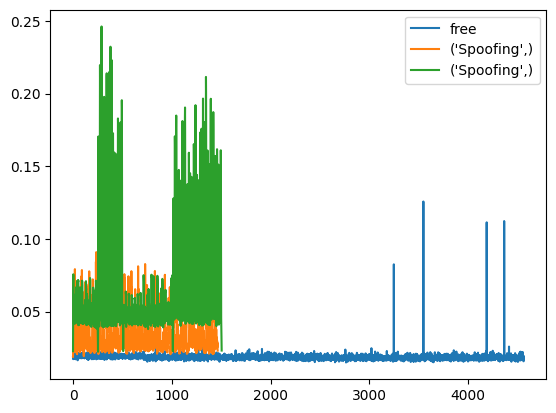

free, 1.270258
58
('Flooding',), 0.000000
('Spoofing',), 0.000000
('Replay',), 0.058514
('Fuzzing',), 0.051493
2
7382
('Flooding',), 0.000000
('Spoofing',), 3.001364
('Replay',), 0.060386
('Fuzzing',), 0.000000
45
7274


In [ ]:
#결과 그래프, 표

plt.plot(f, label='free')

for aa in a:
    if aa == ('Spoofing',):
        plt.plot(a[aa], label=aa)
for aa in a2:
    if aa == ('Spoofing',):
        plt.plot(a2[aa], label=aa)

plt.legend()
plt.show()

cnt1 = 0
limit = 0.022
for ff in f:
    if ff > limit:
        cnt1 += 1
print(f'free, {cnt1*100/len(f):.6f}')
print(cnt1)
cnt3 = 0
cnt4 = 0
for aa in a2:
    cnt2 = 0
    for d in a2[aa]:
        if d < limit:
            cnt2 += 1
    cnt3 += cnt2
    cnt4 += len(a2[aa])
    print(f'{aa}, {cnt2*100/len(a2[aa]):.6f}')
print(cnt3)
print(cnt4)
cnt3 = 0
cnt4 = 0
for aa in a:
    cnt2 = 0
    for d in a[aa]:
        if d < limit:
            cnt2 += 1
    cnt3 += cnt2
    cnt4 += len(a[aa])
    print(f'{aa}, {cnt2*100/len(a[aa]):.6f}')
print(cnt3)
print(cnt4)